# Imports

In [1]:
from rdkit import DataStructs
import os

import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.core.display import display, HTML


from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from rdkit.Chem import AllChem, Descriptors, MolFromSmiles, MolToSmiles
import matplotlib.pyplot as plt


# Main

## Useful Functions

In [2]:
data_dir = '/rds-d7/project/rds-ZNFRY9wKoeE/EnamineREAL/data/'
target = 'mac1'

existing_dirs = [
    data_dir+x for x in os.listdir(data_dir) if os.path.isdir(data_dir+x)]

# Find Top-N

df_all = []
for i, folder in tqdm(enumerate(existing_dirs), total=len(existing_dirs), smoothing=0):
        if os.path.isfile(folder+'/topN_'+target+'.csv'):
            df = pd.read_csv(folder+'/topN_'+target+'.csv')
            df_all.append(df)
        

100%|██████████| 46570/46570 [26:23<00:00, 29.42it/s]


In [3]:
important = ['Donor-Aromatic',
             'Donor-Acceptor',
             'Aromatic-Aromatic']
unimportant = ['Donor-Donor',
               'Aromatic-Acceptor',
               'Acceptor-Acceptor']

pairs = important+unimportant

N = 100000
df_tot = pd.concat(df_all).drop_duplicates(subset=['smiles'], keep='first')

x = df_tot[pairs].to_numpy().astype(float)
x[np.isnan(x)] = -100
df_tot['new_score'] = np.mean(x, axis=1)
df_topn = df_tot.nlargest(n=N, columns='new_score')

# df_tot.to_csv(data_dir+'../topN/new_'+target+'.csv', index=False)
df_topn.to_csv(data_dir+'../topN/topN_new_'+target+'.csv', index=False)
# print(len(df_tot))


In [38]:
df_topn['smiles'].to_csv(data_dir+'../topN/topN_new_'+target+'.csv', index=False)


In [35]:
df = pd.read_csv('../data/activity_data.csv')
df = df[(df['acrylamide'] == False) & (df['chloroacetamide'] == False)]
df.reset_index(inplace=True)

df['mol'] = [MolFromSmiles(x) for x in df['SMILES']]
df_topn['mol'] = [MolFromSmiles(x)
                     for x in df_topn['smiles']]
fprints_moonshot = [AllChem.GetMorganFingerprintAsBitVect(
    mol, radius=3, nBits=2048) for mol in df['mol'].values]
fprints_topn = [AllChem.GetMorganFingerprintAsBitVect(
    mol, radius=3, nBits=2048) for mol in df_topn['mol'].values]

100%|██████████| 1360/1360 [00:10<00:00, 135.47it/s]


<Figure size 2400x1600 with 0 Axes>

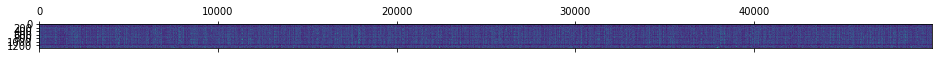

In [36]:
threshold = 0.8
sim_mat = np.empty((len(fprints_moonshot), len(fprints_topn)))
for i in tqdm(range(len(fprints_moonshot))):
    sim_mat[i] = np.array(DataStructs.BulkTanimotoSimilarity(
        fprints_moonshot[i], fprints_topn))

    # inds = np.argwhere(scores).flatten()
    # if inds!=[]:
    #     print(i, inds)
fig = plt.figure(dpi=400)
plt.matshow(sim_mat)

In [37]:
top_n = 100
# print()
# print(np.amax(sim_mat))
max_inds = np.unravel_index(np.argpartition(
    sim_mat.flatten(), -top_n)[-top_n:], shape=((len(fprints_moonshot), len(fprints_topn))))

x = max_inds[0]
y = max_inds[1]
for n in range(top_n):
    print(df_topn.iloc[y[n]]['smiles'], sim_mat[x[n], y[n]])
    display(df.iloc[x[n]][['SMILES', 'CID', 'f_avg_IC50']])
    


[H]Oc1ccc(S(=O)(=O)N([H])[H])cc1C(=O)N([H])c1cncc2ccccc12 0.4268292682926829


SMILES        O=C(Cc1cc(F)cc(F)c1)Nc1cncc2ccccc12
CID                           RAL-THA-2d450e86-16
f_avg_IC50                               0.569448
Name: 569, dtype: object

[H]N([H])C(=O)c1ccc(C(=O)N([H])N([H])C(=O)Cn2cnc3ccccc32)n1[H] 0.4268292682926829


SMILES        O=C(Cn1cnc2ccccc21)Nc1cccc(Cl)c1
CID                        BEN-DND-61647d40-13
f_avg_IC50                             87.1939
Name: 1304, dtype: object

[H]N1C(=O)CN(C(=O)[C@H]2N([H])c3ccccc3S(=O)(=O)N2[H])c2ccncc21 0.42696629213483145


SMILES        CN(C)S(=O)(=O)N1CCN(C(=O)C2Nc3ccccc3S(=O)(=O)N...
CID                                         JAR-KUA-41bd5a3d-13
f_avg_IC50                                                 99.5
Name: 85, dtype: object

[H]N(C(=O)C(=O)N([H])N([H])c1ccnc(F)c1)c1cncc2ccccc12 0.42696629213483145


SMILES        O=C(Cc1cc(F)cc(Cl)c1)Nc1cncc2ccccc12
CID                            RAL-THA-2d450e86-14
f_avg_IC50                                0.382677
Name: 568, dtype: object

[H]N(Cc1ccc(F)c(S(=O)(=O)N([H])[H])c1)C(=O)Cn1nnc2ccccc21 0.42696629213483145


SMILES        O=C(Cn1nnc2ccccc21)Nc1cccc(Cl)c1
CID                        BEN-DND-61647d40-12
f_avg_IC50                                99.5
Name: 1303, dtype: object

[H]N([H])C(=O)[C@H](c1ccc(F)cc1)N([H])C(=O)c1cc(=O)n([H])c2ccccc12 0.42857142857142855


SMILES        O=C(NCCOc1ccccc1)c1cc(=O)[nH]c2ccccc12
CID                               BEN-DND-7e92b6ca-5
f_avg_IC50                                      99.5
Name: 1282, dtype: object

[H]N([H])C(=O)c1ccc(CN([H])C(=O)C(=O)N([H])c2cncc3ccccc23)o1 0.42857142857142855


SMILES        Cc1ccc(CC(=O)Nc2cncc3ccccc23)cc1
CID                         RAL-THA-2d450e86-3
f_avg_IC50                             58.3563
Name: 557, dtype: object

[H]N(CCN(C)C(=O)c1cc(=O)n2ncnc2n1[H])C(=O)c1cccnc1 0.4274193548387097


SMILES        CC(C)(C)c1ccc(N(C(=O)c2cc(=O)n3ncnc3[nH]2)C(C(...
CID                                         ALP-POS-305f6ec3-31
f_avg_IC50                                                 99.5
Name: 618, dtype: object

[H]N([H])C(=O)c1ccc(CN([H])C(=O)C(=O)N([H])c2cncc3ccccc23)o1 0.42857142857142855


SMILES        O=C(Cc1ccc(F)cc1)Nc1cncc2ccccc12
CID                         RAL-THA-2d450e86-7
f_avg_IC50                             4.97036
Name: 561, dtype: object

[H]N([H])c1nccc2c1CN(C(=O)c1cc(=O)n([H])c3ccc(F)cc13)CC2 0.42718446601941745


SMILES        O=C(c1cc(=O)[nH]c2ccc(F)cc12)N1CCN(S(=O)(=O)c2...
CID                                         MAT-POS-590ac91e-69
f_avg_IC50                                                  NaN
Name: 1272, dtype: object

[H]N([H])C(=O)c1ccc(CN([H])C(=O)C(=O)N([H])c2cncc3ccccc23)o1 0.42857142857142855


SMILES        O=C(Cc1ccc(Cl)cc1)Nc1cncc2ccccc12
CID                          RAL-THA-2d450e86-2
f_avg_IC50                              23.6888
Name: 556, dtype: object

[H]N(C(=O)N([H])c1cccc2nonc12)c1cccc(O[C@H]2CC(=O)N2[H])c1 0.43157894736842106


SMILES        O=C(Cc1cccnc1)Nc1cccc(OC2CC(=O)N2)c1
CID                             RAL-MED-2de63afb-1
f_avg_IC50                                 88.3423
Name: 1276, dtype: object

[H]OC[C@H](c1c(F)cccc1F)N([H])C(=O)c1cc(=O)n([H])c2ccccc12 0.42857142857142855


SMILES        O=C(NCCOc1ccccc1)c1cc(=O)[nH]c2ccccc12
CID                               BEN-DND-7e92b6ca-5
f_avg_IC50                                      99.5
Name: 1282, dtype: object

[H]N(Cc1ccccc1N([H])S(C)(=O)=O)C(=O)C(=O)N([H])c1cnccc1C 0.43037974683544306


SMILES        Cc1ccncc1NC(=O)Cc1ccccc1N
CID                  ANN-UNI-98d2bf15-1
f_avg_IC50                         99.5
Name: 1257, dtype: object

[H]Sc1nnc(CC)n1CCN([H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.43119266055045874


SMILES        CC1(C)Cc2cccc(OCCNC(=O)c3cc(=O)[nH]c4cc(F)ccc3...
CID                                         MAT-POS-590ac91e-46
f_avg_IC50                                                 99.5
Name: 1269, dtype: object

[H]N(Cc1cc(S(=O)(=O)N([H])[H])ccc1F)C(=O)Cn1cnc2ccccc21 0.43023255813953487


SMILES        O=C(Cn1cnc2ccccc21)Nc1cccc(Cl)c1
CID                        BEN-DND-61647d40-13
f_avg_IC50                             87.1939
Name: 1304, dtype: object

[H]OC[C@H](c1cccc(F)c1)N([H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.43010752688172044


SMILES        COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2cc(F)ccc12
CID                                   MAT-POS-590ac91e-32
f_avg_IC50                                           99.5
Name: 1265, dtype: object

[H]N([H])C(=O)c1cn(C)nc1N([H])C(=O)c1cc(=O)n([H])c2ccc(F)cc12 0.43157894736842106


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2ccc(F)cc12
CID                                      MAT-POS-590ac91e-41
f_avg_IC50                                           16.4414
Name: 1268, dtype: object

[H]N(C(=O)Cc1ccc2c(cnn2[H])c1)N([H])c1ncnc2c1ncn2[H] 0.42857142857142855


SMILES        Cc1ccncc1NC(=O)Cc1ccc2[nH]ncc2c1
CID                         VLA-UCB-00f2c2b3-2
f_avg_IC50                                 NaN
Name: 1204, dtype: object

[H]N(C(=O)C(=O)N([H])c1cncc2ccccc12)c1nc(Cl)cc(N([H])N([H])[H])n1 0.4318181818181818


SMILES        O=C(Cc1cc(F)cc(Cl)c1)Nc1cncc2ccccc12
CID                            RAL-THA-2d450e86-14
f_avg_IC50                                0.382677
Name: 568, dtype: object

[H]N([H])C(=O)[C@H](c1ccc(F)cc1)N([H])C(=O)[C@@H]1CC(=O)N([H])c2ccccc21 0.43333333333333335


SMILES        COc1ccccc1OCCNC(=O)C1CC(=O)Nc2ccccc21
CID                              MAT-POS-35d3f55a-1
f_avg_IC50                                     99.5
Name: 745, dtype: object

[H]N(C(=O)c1cc(S(=O)(=O)N([H])[H])ccc1OC)c1cncc2ccccc12 0.43333333333333335


SMILES        COc1ccccc1OCCC(=O)Nc1cncc2ccccc12
CID                          MAR-UCB-f313ec4d-3
f_avg_IC50                               96.482
Name: 909, dtype: object

[H]N(Cc1cccc(=O)n1[H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.43478260869565216


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2cc(F)ccc12
CID                                      MAT-POS-590ac91e-40
f_avg_IC50                                           32.9741
Name: 1267, dtype: object

[H]N(C(=O)[C@H](C)N([H])C(=O)Cn1cnnn1)c1nn([H])c2ccc(F)cc12 0.43478260869565216


SMILES        O=C(Cc1cccc(Cl)c1)Nc1n[nH]c2ccc(F)cc12
CID                               EDJ-MED-c8e7a002-9
f_avg_IC50                                      99.5
Name: 874, dtype: object

[H]N(CC(=O)N([H])c1ccc(F)c(F)c1)C(=O)N([H])c1cccc2cnn([H])c12 0.4318181818181818


SMILES        O=C(Cc1cccc(Cl)c1)Nc1cccc2cn[nH]c12
CID                           EDJ-MED-c8e7a002-12
f_avg_IC50                                   99.5
Name: 877, dtype: object

[H]N(Cc1cccc(=O)n1[H])C(=O)c1cc(=O)n([H])c2ccc(F)cc12 0.43478260869565216


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2ccc(F)cc12
CID                                      MAT-POS-590ac91e-41
f_avg_IC50                                           16.4414
Name: 1268, dtype: object

[H]N([H])C(=O)[C@@H](c1ccc(F)cc1)N([H])C(=O)[C@H]1CC(=O)N([H])c2ccccc21 0.43333333333333335


SMILES        COc1ccccc1OCCNC(=O)C1CC(=O)Nc2ccccc21
CID                              MAT-POS-35d3f55a-1
f_avg_IC50                                     99.5
Name: 745, dtype: object

[H]N([H])C(=O)c1cccc(C(=O)N([H])N([H])C(=O)Cn2cnc3ccccc32)n1 0.43373493975903615


SMILES        O=C(Cn1cnc2ccccc21)Nc1cccc(Cl)c1
CID                        BEN-DND-61647d40-13
f_avg_IC50                             87.1939
Name: 1304, dtype: object

[H]N(Cc1ccc2c(c1)OCO2)C(=O)N([H])c1cc(F)cc(S(=O)(=O)N([H])[H])c1 0.43434343434343436


SMILES        CC(C)Cn1cc(NC(=O)NCc2ccc3c(c2)OCO3)c2ccccc2c1=O
CID                                       LON-WEI-4d77710c-55
f_avg_IC50                                                NaN
Name: 991, dtype: object

[H]N([H])C(=O)c1ccc(CN([H])C(=O)C(=O)N([H])c2cncc3ccccc23)o1 0.43209876543209874


SMILES        O=C(Cc1ccccc1)Nc1cncc2ccccc12
CID                      RAL-THA-2d450e86-1
f_avg_IC50                          13.9999
Name: 555, dtype: object

[H]OC[C@H](c1ccc(F)cc1)N([H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.43333333333333335


SMILES        COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2cc(F)ccc12
CID                                   MAT-POS-590ac91e-32
f_avg_IC50                                           99.5
Name: 1265, dtype: object

[H]N(Cc1cc(S(=O)(=O)N([H])[H])ccc1F)C(=O)Cn1nnc2ccccc21 0.4318181818181818


SMILES        O=C(Cn1nnc2ccccc21)Nc1cccc(Cl)c1
CID                        BEN-DND-61647d40-12
f_avg_IC50                                99.5
Name: 1303, dtype: object

[H]N([H])c1nccc2c1CN(C(=O)c1cc(=O)n([H])c3cc(F)ccc13)CC2 0.4326923076923077


SMILES        N#Cc1ccccc1S(=O)(=O)N1CCN(C(=O)c2cc(=O)[nH]c3c...
CID                                         MAT-POS-590ac91e-61
f_avg_IC50                                                  NaN
Name: 1270, dtype: object

[H]OC[C@H](c1ccc(F)cc1F)N([H])C(=O)c1cc(=O)n([H])c2ccccc12 0.43529411764705883


SMILES        O=C(NCCNc1ccccc1)c1cc(=O)[nH]c2ccccc12
CID                               BEN-DND-7e92b6ca-4
f_avg_IC50                                      99.5
Name: 1281, dtype: object

[H]N([H])C(=O)c1cc(C(=O)N([H])[H])cc(N([H])C(=O)COc2ccccc2F)c1 0.4358974358974359


SMILES        O=C(COc1ccccc1F)Nc1ncnc2[nH]cnc12
CID                          COM-UCB-8c7d23dc-1
f_avg_IC50                                  NaN
Name: 1176, dtype: object

[H]N([H])C(=O)[C@H](c1ccc(F)cc1)N([H])C(=O)c1cc(=O)n([H])c2ccccc12 0.43902439024390244


SMILES        O=C(NCCNc1ccccc1)c1cc(=O)[nH]c2ccccc12
CID                               BEN-DND-7e92b6ca-4
f_avg_IC50                                      99.5
Name: 1281, dtype: object

[H]Oc1cccc(C(=O)N([H])CC(=O)N([H])c2cccc3cnn([H])c23)c1 0.46987951807228917


SMILES        O=C(Cc1cccc(Cl)c1)Nc1cccc2cn[nH]c12
CID                           EDJ-MED-c8e7a002-12
f_avg_IC50                                   99.5
Name: 877, dtype: object

[H]OC1(c2ncnn2C)CN(C(=O)[C@@H]2N([H])c3ccccc3S(=O)(=O)N2[H])C1 0.47058823529411764


SMILES        CN(C)S(=O)(=O)N1CCN(C(=O)C2Nc3ccccc3S(=O)(=O)N...
CID                                         JAR-KUA-41bd5a3d-13
f_avg_IC50                                                 99.5
Name: 85, dtype: object

[H]N(CC(=O)N([H])c1cccc(O[C@H]2CC(=O)N2[H])c1)C(=O)c1ccc(C)s1 0.4888888888888889


SMILES        O=C(Cc1cccnc1)Nc1cccc(OC2CC(=O)N2)c1
CID                             RAL-MED-2de63afb-1
f_avg_IC50                                 88.3423
Name: 1276, dtype: object

[H]OC[C@@H](c1nccn1[H])N([H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.4731182795698925


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2cc(F)ccc12
CID                                      MAT-POS-590ac91e-40
f_avg_IC50                                           32.9741
Name: 1267, dtype: object

[H]N([H])C(=O)[C@@H](c1ccccc1)N([H])C(=O)c1cc(=O)n([H])c2ccc(F)cc12 0.5113636363636364


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2ccc(F)cc12
CID                                      MAT-POS-590ac91e-41
f_avg_IC50                                           16.4414
Name: 1268, dtype: object

[H]OC1(c2cnnn2C)CN(C(=O)[C@@H]2N([H])c3ccccc3S(=O)(=O)N2[H])C1 0.47058823529411764


SMILES        CN(C)S(=O)(=O)N1CCN(C(=O)C2Nc3ccccc3S(=O)(=O)N...
CID                                         JAR-KUA-41bd5a3d-13
f_avg_IC50                                                 99.5
Name: 85, dtype: object

[H]OC1(c2ccnn2C)CN(C(=O)[C@@H]2N([H])c3ccccc3S(=O)(=O)N2[H])C1 0.47058823529411764


SMILES        CN(C)S(=O)(=O)N1CCN(C(=O)C2Nc3ccccc3S(=O)(=O)N...
CID                                         JAR-KUA-41bd5a3d-13
f_avg_IC50                                                 99.5
Name: 85, dtype: object

[H]N(C(=O)CCn1cnc2ccccc21)c1cccc(N([H])S(=O)(=O)N([H])[H])c1 0.4470588235294118


SMILES        O=C(Cn1cnc2ccccc21)Nc1cccc(Cl)c1
CID                        BEN-DND-61647d40-13
f_avg_IC50                             87.1939
Name: 1304, dtype: object

[H]Sc1nnc(CCN([H])C(=O)N([H])c2cccc(O[C@H]3CC(=O)N3[H])c2)n1C 0.4421052631578947


SMILES        O=C(Cc1cccnc1)Nc1cccc(OC2CC(=O)N2)c1
CID                             RAL-MED-2de63afb-1
f_avg_IC50                                 88.3423
Name: 1276, dtype: object

[H]OC[C@@H](c1ccc(F)cc1F)N([H])C(=O)c1cc(=O)n([H])c2ccccc12 0.43529411764705883


SMILES        O=C(NCCNc1ccccc1)c1cc(=O)[nH]c2ccccc12
CID                               BEN-DND-7e92b6ca-4
f_avg_IC50                                      99.5
Name: 1281, dtype: object

[H]OC1(c2nccn2C)CN(C(=O)[C@@H]2N([H])c3ccccc3S(=O)(=O)N2[H])C1 0.46511627906976744


SMILES        CN(C)S(=O)(=O)N1CCN(C(=O)C2Nc3ccccc3S(=O)(=O)N...
CID                                         JAR-KUA-41bd5a3d-13
f_avg_IC50                                                 99.5
Name: 85, dtype: object

[H]OC[C@@H](c1ccc(F)cc1)N([H])C(=O)c1cc(=O)n([H])c2ccc(F)cc12 0.48863636363636365


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2ccc(F)cc12
CID                                      MAT-POS-590ac91e-41
f_avg_IC50                                           16.4414
Name: 1268, dtype: object

[H]N(C(=O)c1cc(S(=O)(=O)N([H])[H])ccc1OC)c1cncc2ccccc12 0.45054945054945056


SMILES        O=C(Nc1cncc2ccccc12)c1ccnc2cc(Cl)c(Cl)cc12
CID                                   MAT-POS-d8472c4f-4
f_avg_IC50                                       28.1093
Name: 40, dtype: object

[H]OC[C@H](c1cccc(F)c1)N([H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.43617021276595747


SMILES        COc1ccccc1OC(C)CNC(=O)c1cc(=O)[nH]c2cc(F)ccc12
CID                                      MAT-POS-590ac91e-38
f_avg_IC50                                              99.5
Name: 1266, dtype: object

[H]Sc1nnc(C)n1CCN([H])C(=O)N([H])c1cccc(O[C@H]2CC(=O)N2[H])c1 0.4375


SMILES        O=C(Cc1cccnc1)Nc1cccc(OC2CC(=O)N2)c1
CID                             RAL-MED-2de63afb-1
f_avg_IC50                                 88.3423
Name: 1276, dtype: object

[H]N(Cc1ccc2c(c1)OCO2)C(=O)N([H])c1cccc(N([H])C(=O)OC)c1 0.4479166666666667


SMILES        CC(C)Cn1cc(NC(=O)NCc2ccc3c(c2)OCO3)c2ccccc2c1=O
CID                                       LON-WEI-4d77710c-55
f_avg_IC50                                                NaN
Name: 991, dtype: object

[H]N(C(=O)C(=O)N([H])c1cncc2ccccc12)c1nc(Cl)cc(N([H])N([H])[H])n1 0.4457831325301205


SMILES        O=C(Cc1cc(Cl)cc(Cl)c1)Nc1cncc2ccccc12
CID                              MAT-POS-fce787c2-2
f_avg_IC50                                    1.372
Name: 538, dtype: object

[H]Oc1nccc2c1CN(C(=O)c1cc(=O)n([H])c3cc(F)ccc13)CC2 0.4368932038834951


SMILES        N#Cc1ccccc1S(=O)(=O)N1CCN(C(=O)c2cc(=O)[nH]c3c...
CID                                         MAT-POS-590ac91e-61
f_avg_IC50                                                  NaN
Name: 1270, dtype: object

[H]OC[C@H](c1cc(F)ccc1F)N([H])C(=O)c1cc(=O)n([H])c2ccccc12 0.43529411764705883


SMILES        O=C(NCCNc1ccccc1)c1cc(=O)[nH]c2ccccc12
CID                               BEN-DND-7e92b6ca-4
f_avg_IC50                                      99.5
Name: 1281, dtype: object

[H]OC[C@@H](c1cccc(F)c1)N([H])C(=O)c1cc(=O)n([H])c2ccc(F)cc12 0.4835164835164835


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2ccc(F)cc12
CID                                      MAT-POS-590ac91e-41
f_avg_IC50                                           16.4414
Name: 1268, dtype: object

[H]O[C@H](CN([H])C(=O)Cc1cncc2ccccc12)CN([H])c1ncccn1 0.47435897435897434


SMILES        O=C(Cc1cncc2ccccc12)Nc1ccccc1
CID                     DAR-DIA-23aa0b97-20
f_avg_IC50                          57.4697
Name: 1359, dtype: object

[H]Oc1ccc(S(=O)(=O)N([H])[H])cc1C(=O)N([H])c1cncc2ccccc12 0.4358974358974359


SMILES        O=C(Cc1ccccc1)Nc1cncc2ccccc12
CID                      RAL-THA-2d450e86-1
f_avg_IC50                          13.9999
Name: 555, dtype: object

[H]N([H])C(=O)[C@H](c1ccccc1)N([H])C(=O)c1cc(=O)n([H])c2ccc(F)cc12 0.5113636363636364


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2ccc(F)cc12
CID                                      MAT-POS-590ac91e-41
f_avg_IC50                                           16.4414
Name: 1268, dtype: object

[H]OC[C@H](c1ccc(F)cc1)N([H])C(=O)c1cc(=O)n([H])c2ccc(F)cc12 0.48863636363636365


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2ccc(F)cc12
CID                                      MAT-POS-590ac91e-41
f_avg_IC50                                           16.4414
Name: 1268, dtype: object

[H]OC[C@H](c1ccc(F)cc1)N([H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.48863636363636365


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2cc(F)ccc12
CID                                      MAT-POS-590ac91e-40
f_avg_IC50                                           32.9741
Name: 1267, dtype: object

[H]N(C(=O)N([H])[C@@H](C)c1cncc(F)c1)c1cccc(O[C@H]2CC(=O)N2[H])c1 0.46236559139784944


SMILES        O=C(Cc1cccnc1)Nc1cccc(OC2CC(=O)N2)c1
CID                             RAL-MED-2de63afb-1
f_avg_IC50                                 88.3423
Name: 1276, dtype: object

[H]N(C(=O)CCN([H])S(=O)(=O)c1cccnc1)c1c2ccc(F)cc2nn1[H] 0.46153846153846156


SMILES        O=C(Cc1cccc(Cl)c1)Nc1[nH]nc2cc(F)ccc12
CID                              EDJ-MED-c8e7a002-10
f_avg_IC50                                      99.5
Name: 875, dtype: object

[H]N(Cc1cccc(=O)n1[H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.4942528735632184


SMILES        COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2cc(F)ccc12
CID                                   MAT-POS-590ac91e-32
f_avg_IC50                                           99.5
Name: 1265, dtype: object

[H]OC[C@H](c1nccn1[H])N([H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.4731182795698925


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2cc(F)ccc12
CID                                      MAT-POS-590ac91e-40
f_avg_IC50                                           32.9741
Name: 1267, dtype: object

[H]N(Cc1cccc(N([H])S(C)(=O)=O)c1)C(=O)C(=O)N([H])c1cnccc1C 0.47674418604651164


SMILES        Cc1ccncc1NC(=O)Cc1cc(Cl)cc(NS(C)(=O)=O)c1
CID                                  WIL-MOD-03b86a88-5
f_avg_IC50                                      21.7972
Name: 1186, dtype: object

[H]N(CC(=O)N([H])c1cccc2cnn([H])c12)C(=O)c1ccc(F)c(F)c1 0.47058823529411764


SMILES        O=C(Cc1cccc(Cl)c1)Nc1cccc2cn[nH]c12
CID                           EDJ-MED-c8e7a002-12
f_avg_IC50                                   99.5
Name: 877, dtype: object

[H]Oc1nccc2c1CN(C(=O)[C@@H]1N([H])c3ccccc3S(=O)(=O)N1[H])CC2 0.4444444444444444


SMILES        CN(C)S(=O)(=O)N1CCN(C(=O)C2Nc3ccccc3S(=O)(=O)N...
CID                                         JAR-KUA-41bd5a3d-13
f_avg_IC50                                                 99.5
Name: 85, dtype: object

[H]N(Cc1ccccc1N([H])S(C)(=O)=O)C(=O)Cc1ccc2c(cnn2[H])c1 0.4444444444444444


SMILES        Cc1ccncc1NC(=O)Cc1ccc2[nH]ncc2c1
CID                         VLA-UCB-00f2c2b3-2
f_avg_IC50                                 NaN
Name: 1204, dtype: object

[H]N(C(=O)c1cc(S(=O)(=O)N([H])[H])ccc1OC)c1cncc2ccccc12 0.4482758620689655


SMILES        COc1ccccc1CC(=O)Nc1cncc2ccccc12
CID                       RAL-THA-2d450e86-39
f_avg_IC50                            34.9854
Name: 582, dtype: object

[H]Oc1ccc(OC)cc1CN([H])C(=O)c1cc(=O)n([H])c2ccc(F)cc12 0.44329896907216493


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2ccc(F)cc12
CID                                      MAT-POS-590ac91e-41
f_avg_IC50                                           16.4414
Name: 1268, dtype: object

[H]N([H])C(=O)c1cc(C(=O)N([H])[H])cc(N([H])C(=O)Cc2cc(Cl)ccc2OC)c1 0.45121951219512196


SMILES        COc1ccc(Cl)cc1CC(=O)Nc1cncc2ccccc12
CID                            MAT-POS-3b92565d-1
f_avg_IC50                                1.20236
Name: 1106, dtype: object

[H]Sc1nnc(CC)n1CCN([H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.44


SMILES        COc1ccccc1OC(C)CNC(=O)c1cc(=O)[nH]c2cc(F)ccc12
CID                                      MAT-POS-590ac91e-38
f_avg_IC50                                              99.5
Name: 1266, dtype: object

[H]N(C(=O)CN([H])S(=O)(=O)c1cn(C)cn1)c1nn([H])c2ccc(F)cc12 0.43956043956043955


SMILES        O=C(Cc1cccc(Cl)c1)Nc1n[nH]c2ccc(F)cc12
CID                               EDJ-MED-c8e7a002-9
f_avg_IC50                                      99.5
Name: 874, dtype: object

[H]Sc1nnc(CC)n1CCN([H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.4791666666666667


SMILES        COc1ccccc1OCCNC(=O)c1cc(=O)[nH]c2cc(F)ccc12
CID                                   MAT-POS-590ac91e-32
f_avg_IC50                                           99.5
Name: 1265, dtype: object

[H]N(C(=O)N([H])c1cccc2nsnc12)c1cccc(O[C@H]2CC(=O)N2[H])c1 0.44086021505376344


SMILES        O=C(Cc1cccnc1)Nc1cccc(OC2CC(=O)N2)c1
CID                             RAL-MED-2de63afb-1
f_avg_IC50                                 88.3423
Name: 1276, dtype: object

[H]OC[C@@H](c1nccn1[H])N([H])C(=O)c1cc(=O)n([H])c2ccc(F)cc12 0.4731182795698925


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2ccc(F)cc12
CID                                      MAT-POS-590ac91e-41
f_avg_IC50                                           16.4414
Name: 1268, dtype: object

[H]N([H])C(=O)c1csc(N([H])C(=O)N([H])c2cccc(O[C@H]3CC(=O)N3[H])c2)n1 0.45054945054945056


SMILES        O=C(Cc1cccnc1)Nc1cccc(OC2CC(=O)N2)c1
CID                             RAL-MED-2de63afb-1
f_avg_IC50                                 88.3423
Name: 1276, dtype: object

[H]OC[C@H](c1nccn1[H])N([H])C(=O)c1cc(=O)n([H])c2ccc(F)cc12 0.4731182795698925


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2ccc(F)cc12
CID                                      MAT-POS-590ac91e-41
f_avg_IC50                                           16.4414
Name: 1268, dtype: object

[H]N(CC(=O)N([H])c1cccc2cnn([H])c12)C(=O)c1cc(F)cc(F)c1 0.46987951807228917


SMILES        O=C(Cc1cccc(Cl)c1)Nc1cccc2cn[nH]c12
CID                           EDJ-MED-c8e7a002-12
f_avg_IC50                                   99.5
Name: 877, dtype: object

[H]N(C(=O)CN([H])S(=O)(=O)c1cnn(C)c1)c1nn([H])c2ccc(F)cc12 0.43956043956043955


SMILES        O=C(Cc1cccc(Cl)c1)Nc1n[nH]c2ccc(F)cc12
CID                               EDJ-MED-c8e7a002-9
f_avg_IC50                                      99.5
Name: 874, dtype: object

[H]N(CC(=O)N([H])c1nn([H])c2ccc(F)cc12)C(=O)c1cccc(F)c1 0.5060240963855421


SMILES        O=C(Cc1cccc(Cl)c1)Nc1n[nH]c2ccc(F)cc12
CID                               EDJ-MED-c8e7a002-9
f_avg_IC50                                      99.5
Name: 874, dtype: object

[H]N(Cc1cccc(=O)n1[H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.44


SMILES        CC1(C)Cc2cccc(OCCNC(=O)c3cc(=O)[nH]c4cc(F)ccc3...
CID                                         MAT-POS-590ac91e-46
f_avg_IC50                                                 99.5
Name: 1269, dtype: object

[H]OC[C@H](c1cccc(F)c1)N([H])C(=O)c1cc(=O)n([H])c2ccc(F)cc12 0.4835164835164835


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2ccc(F)cc12
CID                                      MAT-POS-590ac91e-41
f_avg_IC50                                           16.4414
Name: 1268, dtype: object

[H]N(C(=O)CCN([H])S(=O)(=O)c1cccnc1)c1nn([H])c2ccc(F)cc12 0.4666666666666667


SMILES        O=C(Cc1cccc(Cl)c1)Nc1n[nH]c2ccc(F)cc12
CID                               EDJ-MED-c8e7a002-9
f_avg_IC50                                      99.5
Name: 874, dtype: object

[H]Oc1ccc(N([H])S(C)(=O)=O)cc1C(=O)N([H])c1cncc2ccccc12 0.4444444444444444


SMILES        O=C(Nc1cncc2ccccc12)c1ccnc2cc(Cl)c(Cl)cc12
CID                                   MAT-POS-d8472c4f-4
f_avg_IC50                                       28.1093
Name: 40, dtype: object

[H]N(C(=O)CN([H])S(=O)(=O)c1cccc(F)c1)c1cn([H])c2ccccc12 0.43529411764705883


SMILES        O=C(Cc1cccc(Cl)c1)Nc1c[nH]c2ccccc12
CID                            JIN-POS-6dc588a4-5
f_avg_IC50                                   99.5
Name: 217, dtype: object

[H]Oc1ccc(S(=O)(=O)N([H])[H])cc1C(=O)N([H])c1cncc2ccccc12 0.45977011494252873


SMILES        O=C(Nc1cncc2ccccc12)c1ccnc2cc(Cl)c(Cl)cc12
CID                                   MAT-POS-d8472c4f-4
f_avg_IC50                                       28.1093
Name: 40, dtype: object

[H]Oc1cccc(C(=O)N([H])CC(=O)N([H])c2nnc3ccccn23)c1 0.4578313253012048


SMILES        O=C(Cc1cccc(Cl)c1)Nc1nnc2ccccn12
CID                         PET-UNK-e44ffd04-1
f_avg_IC50                                99.5
Name: 866, dtype: object

[H]OC[C@@H](c1cc(F)ccc1F)N([H])C(=O)c1cc(=O)n([H])c2ccccc12 0.43529411764705883


SMILES        O=C(NCCNc1ccccc1)c1cc(=O)[nH]c2ccccc12
CID                               BEN-DND-7e92b6ca-4
f_avg_IC50                                      99.5
Name: 1281, dtype: object

[H]N(Cc1cccc(=O)n1[H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.48314606741573035


SMILES        COc1ccccc1OC(C)CNC(=O)c1cc(=O)[nH]c2cc(F)ccc12
CID                                      MAT-POS-590ac91e-38
f_avg_IC50                                              99.5
Name: 1266, dtype: object

[H]N([H])C(=O)c1csc(N([H])C(=O)N([H])c2cccc(O[C@@H]3CC(=O)N3[H])c2)n1 0.45054945054945056


SMILES        O=C(Cc1cccnc1)Nc1cccc(OC2CC(=O)N2)c1
CID                             RAL-MED-2de63afb-1
f_avg_IC50                                 88.3423
Name: 1276, dtype: object

[H]OC[C@H](c1ccc(F)cc1)N([H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.45555555555555555


SMILES        COc1ccccc1OC(C)CNC(=O)c1cc(=O)[nH]c2cc(F)ccc12
CID                                      MAT-POS-590ac91e-38
f_avg_IC50                                              99.5
Name: 1266, dtype: object

[H]N(C(=O)C(=O)N([H])N([H])c1ccnc(F)c1)c1cncc2ccccc12 0.44047619047619047


SMILES        O=C(Cc1cc(F)cc(F)c1)Nc1cncc2ccccc12
CID                           RAL-THA-2d450e86-16
f_avg_IC50                               0.569448
Name: 569, dtype: object

[H]OC[C@H](c1cccc(F)c1)N([H])C(=O)c1cc(=O)n([H])c2cc(F)ccc12 0.4835164835164835


SMILES        COc1ccccc1OCC(C)NC(=O)c1cc(=O)[nH]c2cc(F)ccc12
CID                                      MAT-POS-590ac91e-40
f_avg_IC50                                           32.9741
Name: 1267, dtype: object

[H]N(C(=O)c1cc(S(=O)(=O)N([H])[H])ccc1OC)c1cncc2ccccc12 0.45054945054945056


SMILES        COc1ccc(Cl)cc1CC(=O)Nc1cncc2ccccc12
CID                            MAT-POS-3b92565d-1
f_avg_IC50                                1.20236
Name: 1106, dtype: object

[H]OC[C@H](c1c(F)cccc1F)N([H])C(=O)c1cc(=O)n([H])c2ccccc12 0.4567901234567901


SMILES        O=C(NCCNc1ccccc1)c1cc(=O)[nH]c2ccccc12
CID                               BEN-DND-7e92b6ca-4
f_avg_IC50                                      99.5
Name: 1281, dtype: object

[H]N(C(=O)CN([H])S(=O)(=O)c1cccc(F)c1)c1nn([H])c2ccc(F)cc12 0.5


SMILES        O=C(Cc1cccc(Cl)c1)Nc1n[nH]c2ccc(F)cc12
CID                               EDJ-MED-c8e7a002-9
f_avg_IC50                                      99.5
Name: 874, dtype: object

[H]N(Cc1cncnc1N([H])[H])C(=O)C(=O)N([H])c1cncc2ccccc12 0.44047619047619047


SMILES        Cc1ccccc1CC(=O)Nc1cncc2ccccc12
CID                      RAL-THA-2d450e86-38
f_avg_IC50                           29.5344
Name: 581, dtype: object

[H]N(C(=O)Cc1cccc2nsnc12)c1cccc(O[C@@H]2CC(=O)N2[H])c1 0.5333333333333333


SMILES        O=C(Cc1cccnc1)Nc1cccc(OC2CC(=O)N2)c1
CID                             RAL-MED-2de63afb-1
f_avg_IC50                                 88.3423
Name: 1276, dtype: object

## Generate Top-N

## Visualise results

In [ ]:
import mols2grid

display_n = 50

mols2grid.display(pd.read_csv(data_dir+'../topN/topN_new_'+target+'.csv').iloc[:display_n].rename(columns={
                  'smiles': 'SMILES'}), template="pages", n_rows=10, n_cols=5, subset=["img"], tooltip=['SMILES', 'mean_score'])


In [7]:
print(len(df_tot.drop_duplicates(subset=['smiles'], keep='first')))

In [2]:
df1 = pd.read_csv(dir2+'topN_final_acc_true.csv')
df2 = pd.read_csv('~/topN_final_acc.csv')
# print(len(df1.drop_duplicates(subset=['smiles'], keep='first')))
print(df1.equals(df2))
smiles_x = df1['smiles'].values
smiles_y = df2['smiles'].values

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

print(len(intersection(smiles_x, smiles_y)))
print(len(df1[df1['dir'].str.contains('rds-d2')]))
print(len(df2[df2['dir'].str.contains('rds-d2')]))

df_overlap = df1.merge(df2, how='inner', on='smiles')
# print(len(df_overlap[df_overlap.duplicated(subset='smiles')]))
# print(len(df_overlap))
print(len(df_overlap[df_overlap['dir_x'].str.contains('rds-d2')]))
print(len(df_overlap[df_overlap['dir_x'].str.contains('rds-d7')]))

In [48]:
print(df1.drop_duplicates(subset=['smiles'], keep='first'))
df1[['smiles','2body_score']].to_csv('~/topN_mpro.csv', index=False)

In [35]:
submitted_mols = [
    'Cc1ccc(NCc2nnc3n(C)c(=O)c4ccccc4n23)cc1C',
    'O=C(Nc1ccc2c(=O)cc[nH]c2c1)c1ccc2ccncc2c1',
    'Cc1cn2ccc(C(=O)Nc3nc(-c4cnn(C)c4)cs3)cc2n1',
    'O=C(Cc1c[nH]c2cc(Cl)ccc12)Nc1cccc2[nH]c(=O)[nH]c12',
    'Cc1nnc(CNc2ccc3nnc(-c4ccccc4)n3n2)o1',
    'CCn1c(CNc2nnc(-c3nccn3C)o2)nc2ccccc21',
    'CN(Cc1nnc2ccccn12)C(=O)c1ccnc2ccccc12',
    'Cc1cc(N2CCC(C)N(Cc3ccccc3)CC2)n2ncnc2n1',
    'O=C(Nc1nn2cnnc2s1)c1csc(-c2ccccc2)n1',
    'Cc1cn2c(CNC(=O)c3cnn4ccccc34)c(C)nc2s1',
    'N#CCc1cccc(NC(=O)c2cnn3cc(Br)cnc23)n1',
    'Cc1ccc(Br)nc1C(=O)NC(C)c1nnc2c(=O)[nH]ccn12',
    'O=C(NNc1nc(Br)cn2ccnc12)c1nccn2ccnc12',
    'O=C(NNc1cc(O)nc2ncccc12)c1ccc2[nH]ccc2c1',
    'Cc1cc(C(=O)Nc2cnc3nccn3c2)nn1-c1ccc(F)cc1',
    'Cn1ccn2c(CNC(=O)c3ccc4ncsc4c3)nnc2c1=O',
    'Cn1c(NC(=O)Cc2csc3nccn23)nc2ccc(F)cc21',
    'O=C(N/N=c1\cc[nH]c2ccccc12)c1ccc2ncccc2c1',
    'Cc1cc(O)c2cc(NC(=O)c3cnn4ccc(C)nc34)ccc2n1',
    'Cc1cccc2ncnc(NC(C)c3ccc4[nH]c(=O)[nH]c4c3)c12',
    'Cc1[nH]c2ccccc2c1C(=O)NNc1nc2cccnc2s1',
    'O=C(Nc1cnc2nccn2c1)c1cn2c(Br)cnc2s1',
    'O=C(Nc1cccc2nccnc12)c1c[nH]c2cc([N+](=O)[O-])ccc12',
    'Cc1ccc(C(=O)Nc2c(-c3cnn(C)c3)nc3ccccn23)cn1',
    'c1ccc2oc(C3CCCN(Cc4cnc5cnccn45)C3)nc2c1',
    'Cn1cnnc1-c1cccc(NS(=O)(=O)c2c(Cl)nc3sccn23)c1',
    'Cn1c(=O)oc2cc(S(=O)(=O)Nc3ccc4ncccc4c3)ccc21',
    'CC(NC(=O)c1c(Cl)nc2ccccn12)c1nnc2ccccn12',
    'CC(NC(=O)c1nccc2cccnc12)c1ccc2[nH]c(=O)oc2c1',
    'Cc1noc2ncc(CNc3ccc(-c4nnnn4C)cc3)cc12',
    'CC(NC(=O)c1cnc2sccn2c1=O)c1nc2ccccc2n1C',
    'c1cc(CN2CCCC(c3nnc4ccccn34)C2)n2ccnc2c1',
    'Cc1nc2sccn2c1CN(C)C(=O)c1cn2ccccc2n1',
    'CN(Cc1nc2ccccc2s1)C(=O)c1ccc2c(c1)nnn2C',
    'CC(Cc1nc2ccccc2s1)Nc1ccc2nnnn2n1',
    'Cc1csc2ncc(C(=O)Nc3cccc4ncccc34)c(=O)n12',
    'O=C(NNc1nc2ccccc2[nH]1)c1cc(O)nc2ccccc12',
    'O=C(Nc1cccc2cc[nH]c12)c1cccc2[nH]c(=O)oc12',
    'Cn1c(NC(=O)c2cccnc2-n2cccn2)nc2cc(F)ccc21',
    'Cc1nn2c(CNc3ccc(Cn4cncn4)cc3)c(C)nc2s1',
    'CC(CNC(=O)c1cnc2ccccn12)Nc1nc2ccccc2o1',
    'Cc1nc2cc(C(=O)NNc3nc4ccncc4s3)ccc2o1',
    'Cc1nn(C)c2nc(Cl)cc(NNC(=O)c3ccnc4[nH]nnc34)c12',
    'COc1ccc(CNCCc2cn3ccsc3n2)cc1OC(F)F',
    'CC(NC(=O)c1ccc2oc(=S)[nH]c2c1)c1nnc2ccccn12',
]

def return_canon(smi):
    mol = MolFromSmiles(smi)
    Chem.RemoveStereochemistry(mol)
    return MolToSmiles(mol)

submitted_mols = [return_canon(smi) for smi in submitted_mols]
df_sub = pd.DataFrame(submitted_mols, columns=['smiles'])
df2['cansmiles'] = [return_canon(smi) for smi in df2['smiles']]
df_sub = df2[df2['cansmiles'].isin(submitted_mols)].drop_duplicates(subset=['cansmiles'], keep='first')

# print(df_sub[~df_sub['smiles'].isin(df2['cansmiles'])].drop_duplicates(subset=['smiles'], keep='first'))
# print(len(df2[df2['cansmiles'].isin(submitted_mols)].drop_duplicates(subset=['cansmiles'], keep='first')))

In [89]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
%matplotlib inline

# actual_scores = []
# # for i,row in tqdm(df2[df2['dir'].str.contains('rds-d2')].iterrows(), total=len(df2[df2['dir'].str.contains('rds-d2')])):
# for i,row in tqdm(df2.iterrows(), total=len(df2)):
#     smi = row['smiles']
#     path = row['dir']
#     df = pd.read_csv(path+'/scores_acc.csv')
#     actual_score = df[df['smiles']==smi]['2body_score'].values[0]
#     actual_scores.append(actual_score)

# actual_scores = np.array(actual_scores)
# # print(actual_scores)
# _, bins, _ = plt.hist(actual_scores[actual_scores<10], bins=30, alpha=0.7, histtype='stepfilled', 
#          label='Including Don-Acc')
# plt.hist(df2['2body_score'].values, bins=bins, alpha=0.7, histtype='stepfilled', 
#           label='Submitted Scores')
         
    
# actual_scores_sub = []
n_wrong = 0
for i,row in tqdm(df_sub.iterrows(), total=len(df_sub)):
    smi = row['smiles']
    path = row['dir']
    ind = row['ind']
    df = pd.read_csv(path+'/scores_acc.csv')
    actual_score = df[df['smiles']==smi]['2body_score'].values[0]
    if actual_score != row['2body_score']:
        print(path)
        print(smi)
        print(actual_score)
        print(row['2body_score'])
        n_wrong+=1
print(n_wrong)
#     actual_scores_sub.append(actual_score)
    
# actual_scores_sub = np.array(actual_scores_sub)
# _, bins, _ = plt.hist(actual_scores_sub, bins=10, alpha=0.7, histtype='stepfilled', 
#          label='Including Don-Acc')
# print(bins)
# print(actual_scores_sub)
# plt.hist(df_sub['2body_score'].values, bins=bins, alpha=0.7, histtype='stepfilled', 
#           label='Submitted Scores')    
    
# plt.hist([x, y], density=True, bins=bins) # alternating

plt.title('top-N Molecules')
# plt.title('Submitted Molecules')

plt.xlabel('2body_score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
# plt.xlim(right=10)
plt.show()
# print(len(df_sub['2body_score'].values))
# print(len(actual_scores_sub[actual_scores_sub<10]))

In [34]:
from rdkit import DataStructs
from rdkit.Chem import AllChem

missing_mols = ['Cc1[nH]c2ccccc2c1C(=O)NNc1nc2cccnc2s1', 'O=C(NNc1nc2ccccc2[nH]1)c1cc(O)nc2ccccc12']

fp_missing = [AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(smi), radius=3, nBits=1024) for smi in missing_mols]
fps = [AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(smi), radius=3, nBits=1024) for smi in df2['cansmiles']]

threshold = 0.5

for i in range(len(fp_missing)):
    print('\n{}'.format(missing_mols[i]))
    for j in range(len(fps)):
        sim = DataStructs.FingerprintSimilarity(fp_missing[i], fps[j])
        if sim>threshold:
            print(df2.iloc[j]['cansmiles'])

In [ ]:
import pickle 

dirs_to_dl = df1['dir'].value_counts()
rescore_dirs = []
for path in tqdm(dirs_to_dl.index):
        pairs = [file for file in os.listdir(path) if "pairs_mpi_" in file]
        if len(pairs)!=0:
            print(len(pairs))
        smi_len = len(open(path+'/mols.smi','r').read().splitlines())
        pickle_len = len(pickle.load(open(path+'/pairs.pickle','rb')))
        
        if smi_len != pickle_len:
#             print(path)
#             print(smi_len, pickle_len)
            rescore_dirs.append(path)
            
print('Num bad dirs: {}'.format(len(rescore_dirs)))

print(len(df1))
print(len(df1[df1['dir'].str.contains('rds-d2')]))
print(len(df1[df1['dir'].str.contains('rds-d7')]))

# good_dirs = 
# score_dirs = df_tot.groupby('dir')

print(len(df1[~df1['dir'].isin(rescore_dirs)]))

In [ ]:
mols2grid.save(df_tot, template="pages", n_rows=10, n_cols=5, subset=["img"], tooltip=['SMILES'], 
               output=dir2+'topN_grid_acc.html')